# Training a random forest classifier to label a character's primary class
Here, we utilize the D&D character loader to facilitate the training of a random forest classifier to predict a character's primary class. A few assumptions at the outset:

  * A character's "primary" class is their highest-level class. This is far from perfect, but seemes reasonable (e.g. many players will take a level of Rogue or a level of Monk, etc., to get access to certain perks). The primary class is the class around which the player will structure their attributes and loadout.
  * A random forest is a reasonable choice of classifier. I imagine that because certain otherwise-dissimilar characters might tend to share very specific features (e.g. sorcerers and paladins will usually have high charisma, but little else in common, while both bards and fighters may tend to equip swords), the feature space is laden with all kinds of non-linear, discontinuous separations and is well-suited to a forest model. It would be interesting to assess other classifiers, but I make no effort to do so here (nor do I do any tuning of my random forest -- this is just a demo!)
  
We start by loading the data.

In [1]:
import sys
from dndmlpy.character_loading_pipeline import load_json, json_to_list_of_characters, all_skills, popular_weapons, build_input_data, build_output_data, filter_charlist

In [2]:
json_file = "lib/dnddata/data-raw/dnd_chars_unique.json"
loaded_json = load_json(json_file)
character_list = json_to_list_of_characters(loaded_json)
character_list = filter_charlist(character_list)

Here's what this (lean) representation of a character looks like.

In [3]:
print(character_list[0])


Name: nostalgic_turing Druid 20
Race: Genasi
Level: 20

Attributes:
    * Strength: 15
    * Dexterity: 17
    * Constitution: 20
    * Intelligence: 18
    * Wisdom: 20
    * Charisma: 14

Classes: 
    * Druid: 20

Proficient Skills:
    * Nature
    * Religion
    * Animal Handling
    * Medicine

Weapons:
    * Scimitar
    * Quarterstaff

        


As you can see, only some of the information from the character sheet is stored; this could be extended relatively easily.

The next thing we need to do is generate some high-level statistics that will facilitate the generation of vectors describing a character's weapons and skill proficiencies. There are a number of ways one could go about this, but to keep it simple, I've taken a one-hot-style approach, where we (for example) look at all of the possible skills, then return a vector indicating a character's proficiency (or lack thereof) in each of those skills. Rather than hard-coding a list of possible skills, I've been lazy and instead constitute this list from the data set.

In [4]:
list_of_possible_skills = all_skills(character_list)
print(list_of_possible_skills)

['Acrobatics', 'Animal Handling', 'Arcana', 'Athletics', 'Deception', 'History', 'Insight', 'Intimidation', 'Investigation', 'Medicine', 'Nature', 'Perception', 'Performance', 'Persuasion', 'Religion', 'Sleight of Hand', 'Stealth', 'Survival']


Weapons are a bit trickier. Many fully-verbose weapon names are essentially unique (e.g. "Sergeant Kate's Orc-Clobbering Mace of Power +2") and will make the feature space much larger without adding much info. To mitigate this, I've added a so-called popularity fraction. If the popularity threshold is X, only weapons for which (# of characters with this weapon) / (total # of characters) > X will be included.

In [5]:
popularity_threshold = 0.005
list_of_popular_weapons = popular_weapons(character_list, popularity_threshold)
print(list_of_popular_weapons)

['Scimitar', 'Quarterstaff', 'Crossbow, light', 'Mace', 'Trident', 'Unarmed Strike', 'Longbow', 'Warhammer', 'Javelin', 'Glaive', 'Dagger', 'Longsword', 'Battleaxe', 'Unarmed strike', 'Dart', 'Sickle', 'Crossbow, Light', 'Shortsword', 'Greatsword', 'Handaxe', 'Spear', 'Shortbow', 'Rapier', 'Shortsword.1', 'Crossbow, hand', 'Dagger.1', 'Greataxe', 'Whip', 'Crossbow, Hand', 'Morningstar', 'Crossbow, heavy', 'Lance', 'Halberd', 'Club', 'Maul', 'Flail', 'Sling', 'Greatclub', 'Light hammer']


These lists above are fed back into the Character objects to generate the one-hot vector. As an example:

In [6]:
skills_onehot_for_example_character = character_list[0].skills_onehot(list_of_possible_skills)
for idx, skill in enumerate(list_of_possible_skills):
    print("Character is proficient in {}: {}".format(skill, skills_onehot_for_example_character[idx]))

Character is proficient in Acrobatics: 0
Character is proficient in Animal Handling: 1
Character is proficient in Arcana: 0
Character is proficient in Athletics: 0
Character is proficient in Deception: 0
Character is proficient in History: 0
Character is proficient in Insight: 0
Character is proficient in Intimidation: 0
Character is proficient in Investigation: 0
Character is proficient in Medicine: 1
Character is proficient in Nature: 1
Character is proficient in Perception: 0
Character is proficient in Performance: 0
Character is proficient in Persuasion: 0
Character is proficient in Religion: 1
Character is proficient in Sleight of Hand: 0
Character is proficient in Stealth: 0
Character is proficient in Survival: 0


Just to belabor the point about how this encoding works, if we reference the character representation listed above, we see that the character is proficient in Nature, Religion, Animal Handling, and Medicine. Indeed, these are the only skills for which the value of the skills onehot is "1". The rest are "0". Let's move on to some actual modeling. First, we'll build a feature using _only_ the character's attributes -- no skills or weapons.

In [7]:
feature_matrix_attributes_only, _ = build_input_data(
    character_list,
    possible_skills_list=list_of_possible_skills,
    possible_weapons_list=list_of_popular_weapons,
    include_attributes=True,
    include_skills=False,
    include_weapons=False,
    include_char_names=True,
)
class_labels = build_output_data(character_list)

With some juicy, numerical data in hand, let's train a random forest classifier to map a this feature vector to a class. The steps below are fairly standard; I'm not attempting to optimize or tune the model here. 

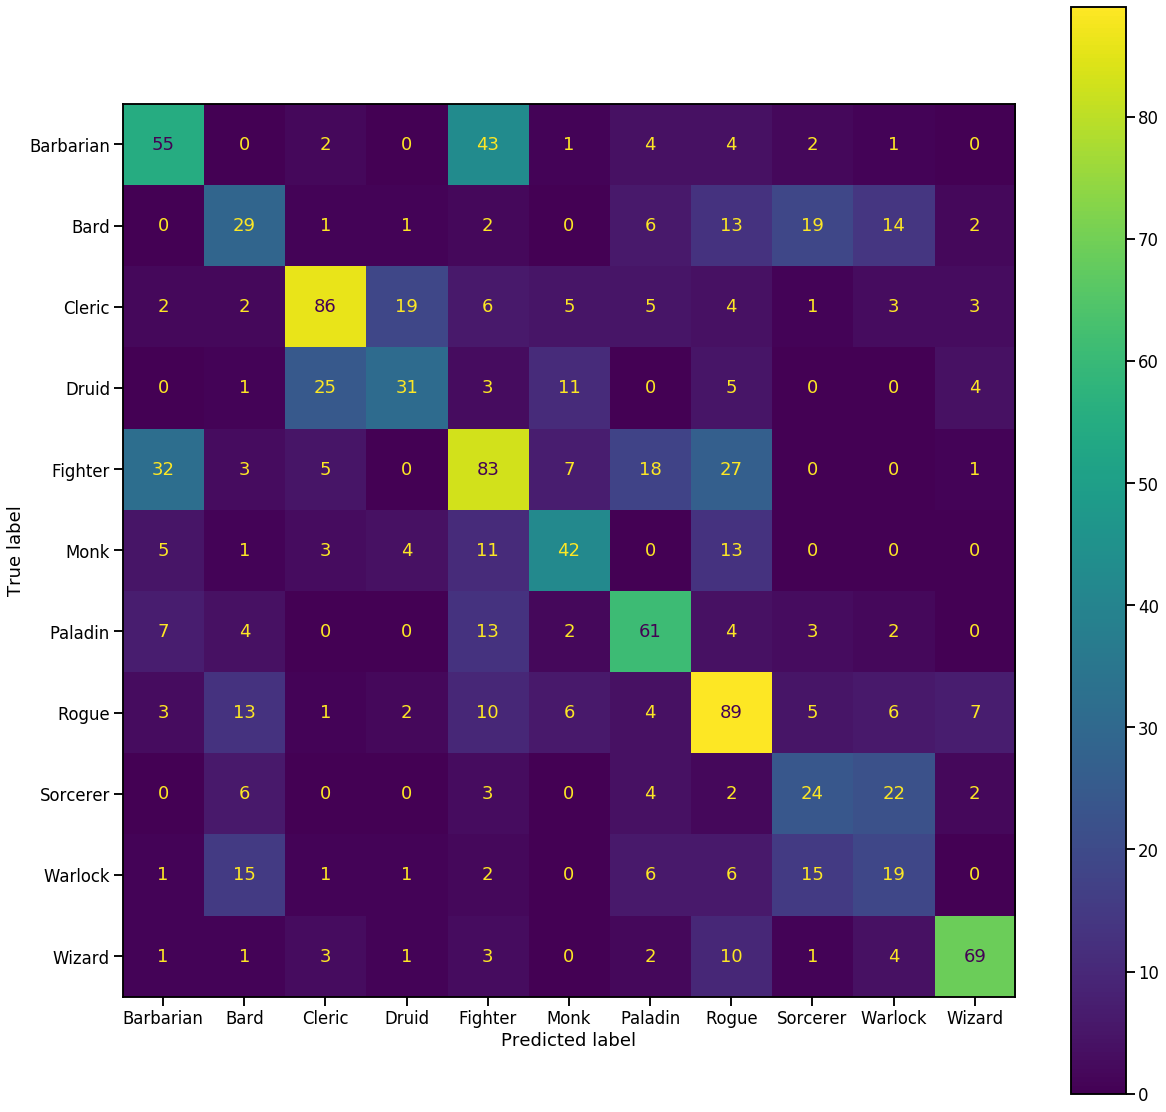

In [8]:
%matplotlib inline
import seaborn as sns
from dndmlpy.analysis_utils import train_visualize_random_forest
sns.set_context("talk")
labels_by_character, _, _ = train_visualize_random_forest(feature_matrix_attributes_only, class_labels, rf_estimators=25)

The diagonal on this confusion matrix is pretty strong, indicating that even with attributes alone, we can do a _reasonably_ good job of predicting the character class. Still, there are some (expected) confusions -- for example, Fighters are very frequently mistaken for Barbarians by the classifier, which isn't surprising in light of how similar their attribute loadouts tend to be. Let's see how we perform if we use attributes, skills, and weapons.

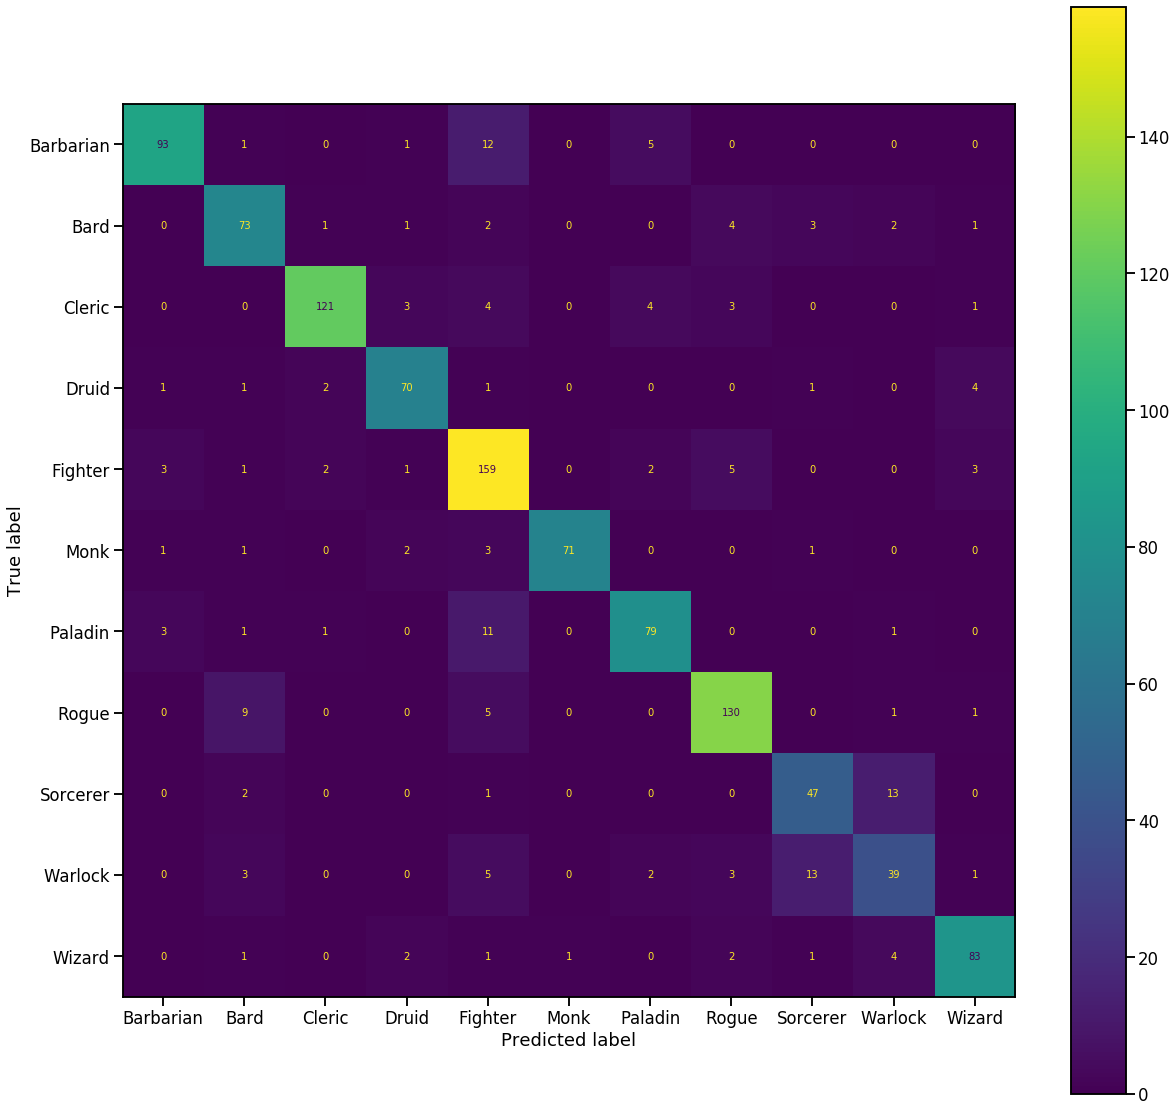

In [9]:
full_feature_matrix, feature_labels = build_input_data(
    character_list,
    possible_skills_list=list_of_possible_skills,
    possible_weapons_list=list_of_popular_weapons,
    include_attributes=True,
    include_skills=True,
    include_weapons=True
)
labels_by_character, feature_importances, feature_indices = train_visualize_random_forest(full_feature_matrix, class_labels, rf_estimators=25)

__Much__ better! Although there are still some exceptions, nearly every character in the test set is correctly classified. It's interesting to note that the skills and weapons do contain information that let us better predict a character's primary class. Out of curiosity, let's look at which features most strongly predict a character's class. I used permutation importance to measure this. This was mostly for fun, but also because attributes (0 - ~20) have somewhat higher cardinality than the individual one-hot vectors, so it's (possibly) a principled choice.

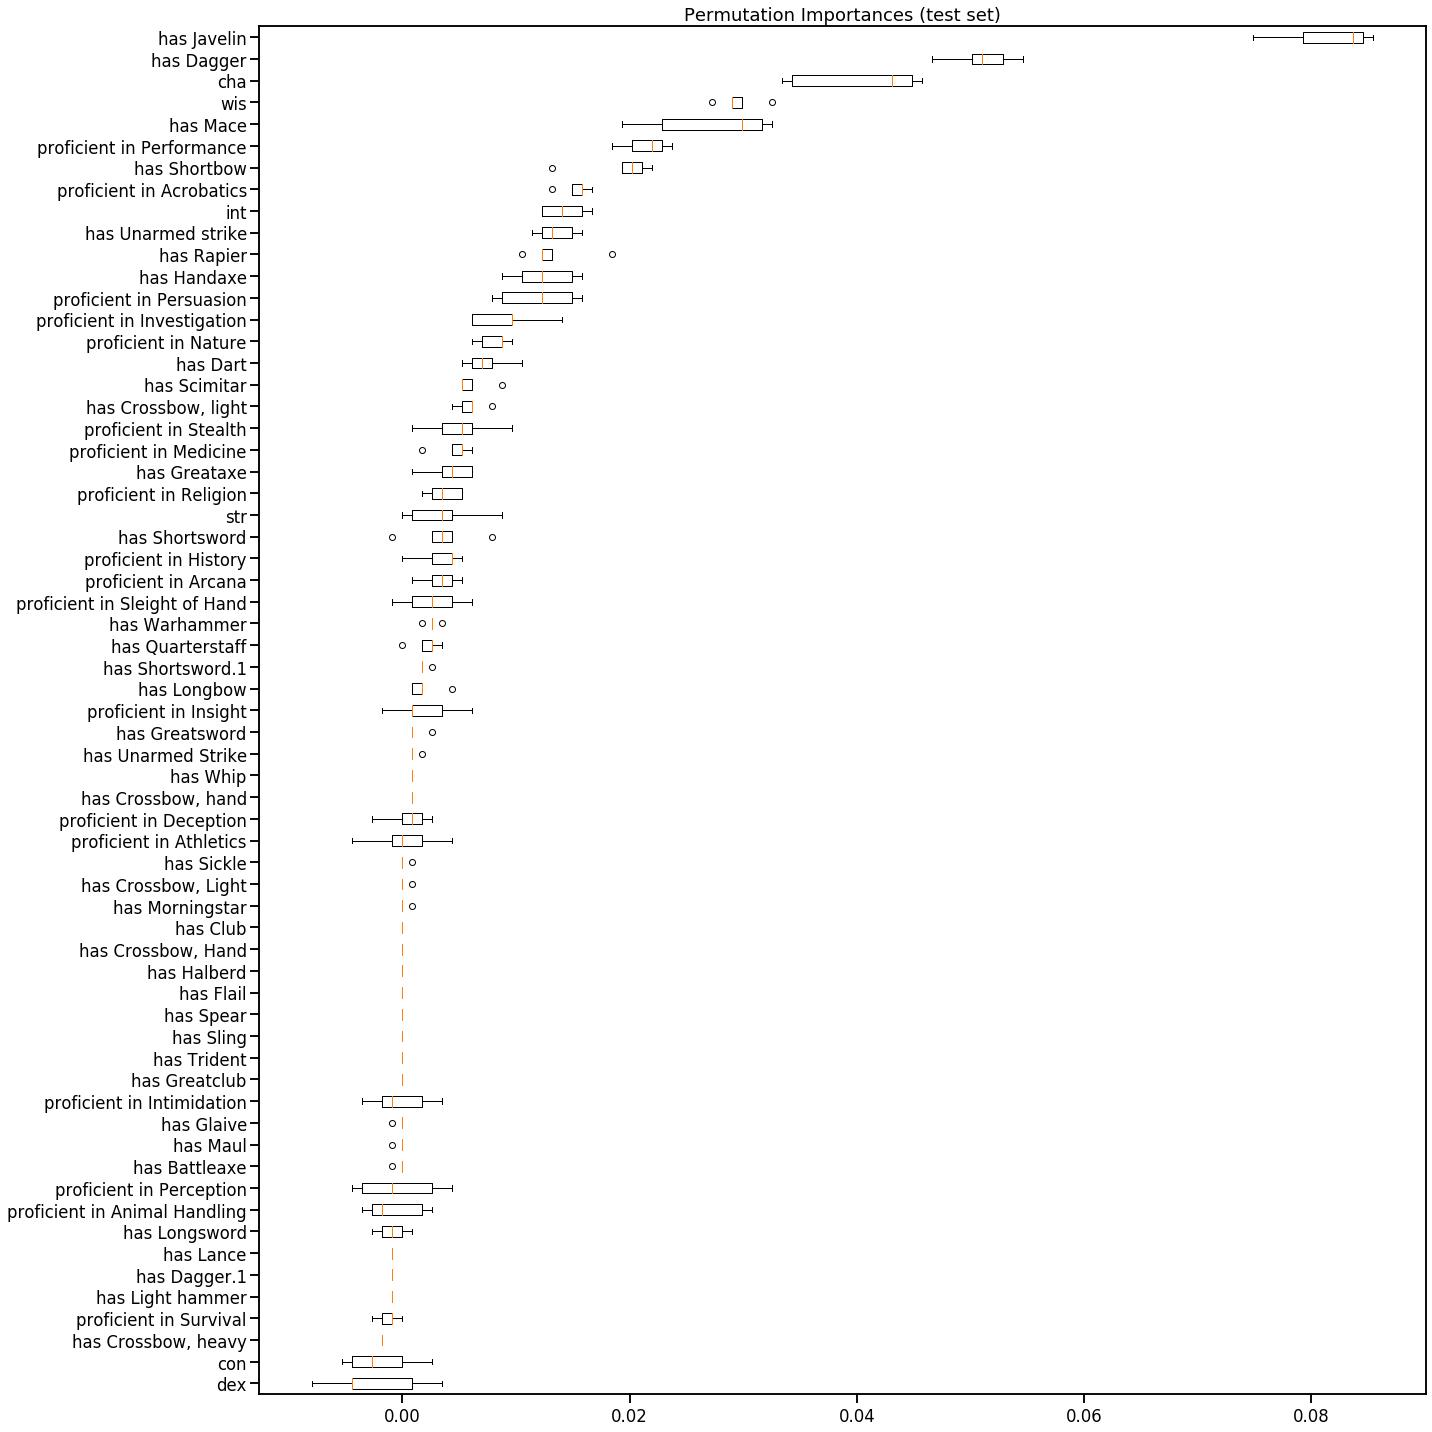

In [10]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(20,20))
ax.boxplot(feature_importances.importances[feature_indices].T,
           vert=False, labels=[feature_labels[x] for x in feature_indices])
ax.set_title("Permutation Importances (test set)")
fig.tight_layout()
plt.show()

I _think_ this is implemented correctly. I'm not surprised to see Charisma so high up there -- in aggregate, it tends to either be a dump stat or it isn't, depending on class. What's more surprising is that "has javelin" is the most predictive feature, but "has spear" is way down there. They don't differ much from spears, but javelins are one of the starting weapon options for paladins, so I wonder if that's where this is coming from.